# Standard Imports

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

# Constants

In [45]:
seed = 42

# Import data

In [46]:
# Chemical and Instrumental Assessment of Green Tea Sensory Preference - Y.R. Liang, Q. Ye, J. Jin, H. Liang, J.L. Lu, Y.Y. Du & J.J. Dong
# https://doi.org/10.1080/10942910701299430
# Notes: downloaded CSVs

df_10942910701299430_chemical_composition = pd.read_csv('../data/10942910701299430/chemical_composition.csv', index_col=0, header=1)
df_10942910701299430_sensory_evaluation = pd.read_csv('../data/10942910701299430/sensory_evaluation.csv')

# Phytochemical Composition and Antioxidant Capacity of 30 Chinese Teas - by Guo-Yi Tang, Cai-Ning Zhao, Xiao-Yu Xu, Ren-You Gan, Shi-Yu Cao, Qing Liu, AoShang, Qian-Qian Mao & Hua-Bin Li
# https://doi.org/10.3390/antiox8060180
# Notes: Manually scraped data

df_antiox8060180_chemical_composition = pd.read_csv('../data/antiox8060180/chemical_composition.csv')

# Catechin and caffeine content of tea (Camellia sinensis L.) leaf significantly differ with seasonal variation... - Himangshu Deka, Tupu Barman, Jintu Dutta, Arundhuti Devi, Pradip Tamuly, Ranjit Kumar Paul & Tanmoy Karak 
# https://doi.org/10.1016/j.jfca.2020.103684
# https://krishi.icar.gov.in/jspui/bitstream/123456789/68751/2/S0889157520313892-main.pdf - Free access

# df_j.jfca.2020.103684_chemical_composition = pd.read_csv('dava/j.jfca.2020.103684/chemical_composition.csv')

# Comparative analysis of tea catechins and theaflavins by high-performance liquid chromatography and capillary electrophoresis - Bee-Lan Lee & Choon-Nam Ong
# https://doi.org/10.1016/S0021-9673(00)00215-6
# Notes: Manually scraped data

df_S0021967300002156 = pd.read_csv('../data/S0021967300002156/chemical_composition.csv')

# Survey of Catechins, Gallic Acid, and Methylxanthines in Green, Oolong, Pu-erh, and Black Teas - Jen-Kun Lin, Chih-Li Lin, Yu-Chih Liang, Shoei-Yn Lin-Shiau & I-Ming Juan
# https://doi.org/10.1021/jf980223x
# Notes: Manually scraped data

df_jf980223x = pd.read_csv('../data/jf980223x/chemical_composition.csv')


In [47]:
# List of all imported dataframes
all_dataframes = [df_10942910701299430_chemical_composition,
                  df_10942910701299430_sensory_evaluation,
                  df_antiox8060180_chemical_composition,
                  df_S0021967300002156,
                  df_jf980223x]

# Combine data

To combine the data I am going to create a data pipeline that does the following:

1. Add all the pandas dataframes to a list.
2. Read that list into a function.
3. The function reads an individual dataframe from that list then resets the index, rename catechins to be like the catechin dictionary below, drop unused columns, add columns that are part of the standardized column format, and then sorts the columns to be part of the standardized column format.
4. The function will then add the dataframe to a list denoting it is processed.
5. Once the function has processed all the dataframes in the lists it will loop through the data frames in the finished list and concatenate them.
6. The function will return a combined dataframe.

## Data Frame Format

The data frames will be combined into the following format:

- `'Catechin'`
- `'Epicatechin'`
- `'Gallocatechin'`
- `'Epigallocatechin'`
- `'Catechin Gallate'`
- `'Epicatechin Gallate'`
- `'Gallocatechin Gallate'`
- `'Epigallocatechin Gallate'`
- `'Gallic Acid'`
- `'Chlorogenic Acid'`
- `'Caffeine'`
- `'Taste'`
- `'Appearance'`
- `'Aroma'`
- `'Liqour color'`


In [48]:
catechin_dictionary = {
    'C': 'Catechin',
    'EC': 'Epicatechin',
    'GC': 'Gallocatechin',
    'EGC': 'Epigallocatechin',
    'CG': 'Catechin Gallate',
    'ECG': 'Epicatechin Gallate',
    'GCG': 'Gallocatechin Gallate',
    'EGCG': 'Epigallocatechin Gallate'
}

standardized_columns = [
    'Catechin',
    'Epicatechin',
    'Gallocatechin',
    'Epigallocatechin',
    'Catechin Gallate',
    'Epicatechin Gallate',
    'Gallocatechin Gallate',
    'Epigallocatechin Gallate',
    'Caffeine',
    'Taste',
    'Appearance',
    'Aroma',
    'Liqour color'
]

In [49]:
df_jf980223x['EC'].dtype == 'float64'

True

To faciliate scability I am create a sklearn pipeline and process all my data to be concatenated.
First I will define the functions that will go into my data preprocessing pipeline.

In [50]:
def reset_index(dataframe: pd.DataFrame):
    return dataframe.reset_index(drop=1)

def rename_columns(dataframe: pd.DataFrame):
    return dataframe.rename(columns=catechin_dictionary)

def drop_nonstandardized_columns(dataframe: pd.DataFrame):
    return dataframe.drop(columns=[column for column in dataframe if column not in standardized_columns])

def reformat_columns(dataframe: pd.DataFrame):
    return dataframe.reindex(columns=standardized_columns)

def remove_standard_deviation_format(dataframe: pd.DataFrame):
    for column in range(len(dataframe)):
        if (dataframe.iloc[column].dtype == 'object') or (dataframe.iloc[column].dtype == 'string'):
            dataframe.iloc[column] = dataframe.iloc[column].str.replace('± \d*.\d*', '', regex=True)
    return dataframe    

Next, the data pipeline applies all of those functions to the inputed dataset.

In [51]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

ResetIndexTransformer = FunctionTransformer(reset_index)
RenameColumnsTransformer = FunctionTransformer(rename_columns)
DropNonstandardizedColumnsTransformer = FunctionTransformer(drop_nonstandardized_columns)
ReformatColumnsTransformer = FunctionTransformer(reformat_columns)
RemoveStandardDeviationFormat = FunctionTransformer(remove_standard_deviation_format)

data_combining_pipeline = make_pipeline(
    ResetIndexTransformer,
    RenameColumnsTransformer,
    DropNonstandardizedColumnsTransformer,
    ReformatColumnsTransformer,
    RemoveStandardDeviationFormat
)


Now I am creating a pipeline that transforms each dataframe then concatenates it and returns one dataframe to be used for the model.

In [52]:
def process_dataframes(dataframes: list):
    processed_dataframes = []
    for dataframe in dataframes:
        dataframe = data_combining_pipeline.fit_transform(dataframe)
        processed_dataframes.append(dataframe)
    return processed_dataframes

def concatenate_dataframes(dataframes: list):
    formated_dataframe = pd.concat(dataframes, ignore_index=True)
    return formated_dataframe

def change_dtypes(dataframe: pd.DataFrame):
    for column in dataframe.columns:
        dataframe[column] = pd.to_numeric(dataframe[column], errors='coerce')
    return dataframe

In [53]:
ProcessDataframes = FunctionTransformer(process_dataframes)
ConcatenateDataframes = FunctionTransformer(concatenate_dataframes)
Change_Dtypes = FunctionTransformer(change_dtypes)

data_combining_pipeline_processor = make_pipeline(
    ProcessDataframes,
    ConcatenateDataframes,
    Change_Dtypes
)

In [55]:
df = data_combining_pipeline_processor.transform(all_dataframes)
df # Note: right now continguous data sets like df_10942910701299430_chemical_composition & df_10942910701299430_sensory_evaluation are not being put together, I need to decide where to combine them: the data pipeline or on inital import.

,Catechin,Epicatechin,Gallocatechin,Epigallocatechin,Catechin Gallate,Epicatechin Gallate,Gallocatechin Gallate,Epigallocatechin Gallate,Caffeine,Taste,Appearance,Aroma,Liqour color
0,8.93,7.04,8.36,18.00,3.72,4.66,21.50,21.11,31.47,NaN,NaN,NaN,NaN
1,9.87,NaN,22.55,10.92,5.33,5.29,26.62,23.42,39.24,NaN,NaN,NaN,NaN
2,6.37,4.92,21.87,10.98,5.29,5.43,24.84,23.63,41.08,NaN,NaN,NaN,NaN
3,6.78,5.91,23.08,11.47,5.76,6.43,25.34,22.14,50.97,NaN,NaN,NaN,NaN
4,5.82,5.60,24.12,13.35,5.28,5.94,27.92,25.09,53.70,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.02,1.06,NaN,1.17,NaN,1.84,0.26,13.77,6.72,NaN,NaN,NaN,NaN
77,0.02,1.15,NaN,1.19,NaN,2.59,0.56,18.81,8.62,NaN,NaN,NaN,NaN
78,0.02,0.92,NaN,0.95,NaN,2.04,0.33,14.88,6.90,NaN,NaN,NaN,NaN
79,0.03,1.05,NaN,0.93,NaN,1.95,0.24,14.69,7.80,NaN,NaN,NaN,NaN


# Data Explanation
f
The data we will be examining and training on is purely numerical. This has many advantages in terms of cleaning and training but a few disadvantages that may not be readily appearant. The catechins and caffeine are all listed in milligrams. What is taste, appearance, aroma, and liquor color measured in? Milligrams? No, instead it is much more complicated. Thankfully this is a pretty standardized tea tasting scoring system throughout China so most of our data will reflect that, any data that does not reflect that will be modified into this scoring system. The scoring system is outlined below:


    Scoring System: They used a scoring system where the highest possible score for a tea sample was 100. This score was divided into different categories, each representing a different aspect of the tea:
        Dry Tea Appearance (10% of the total score): This is about how the tea leaves look when they are dry. The experts looked at the color, size, how tender the leaves were, and how evenly the leaves were twisted.
        Aroma (30% of the total score): This is about how the tea smells.
        Liquor Color (10% of the total score): This is about the color of the tea when it's steeped in water.
        Taste (30% of the total score): This is, of course, about how the tea tastes.
        Infused Leaf (20% of the total score): After the tea has been steeped, the experts looked at the leaves again to see their color, size, tenderness, and evenness.

    How They Tested:
        Dry Tea Appearance: They placed 200 grams of dry tea on a wooden tray (20 cm x 20 cm) and scored it based on the criteria mentioned above.
        Preparing the Tea: For testing aroma, liquor color, and taste, they steeped 3 grams of the tea in 150 milliliters of boiling water for 5 minutes.
        Tasting and Scoring: The tea was then poured into a special tasting bowl. The experts compared the aroma, color, and taste of the tea to three reference samples they had in their lab to give their scores.
        Infused Leaf: Finally, they put the steeped leaves into a porcelain tray with cold water and scored them based on color, size, tenderness, and evenness.



# Exploratory Data Analysis

This pairplot offers a high-level visualization of what is going on internally in the dataset. Next, we will examine further the intricacies of the data before cleaning it further and imputing data using a Generative Adversarial Network.

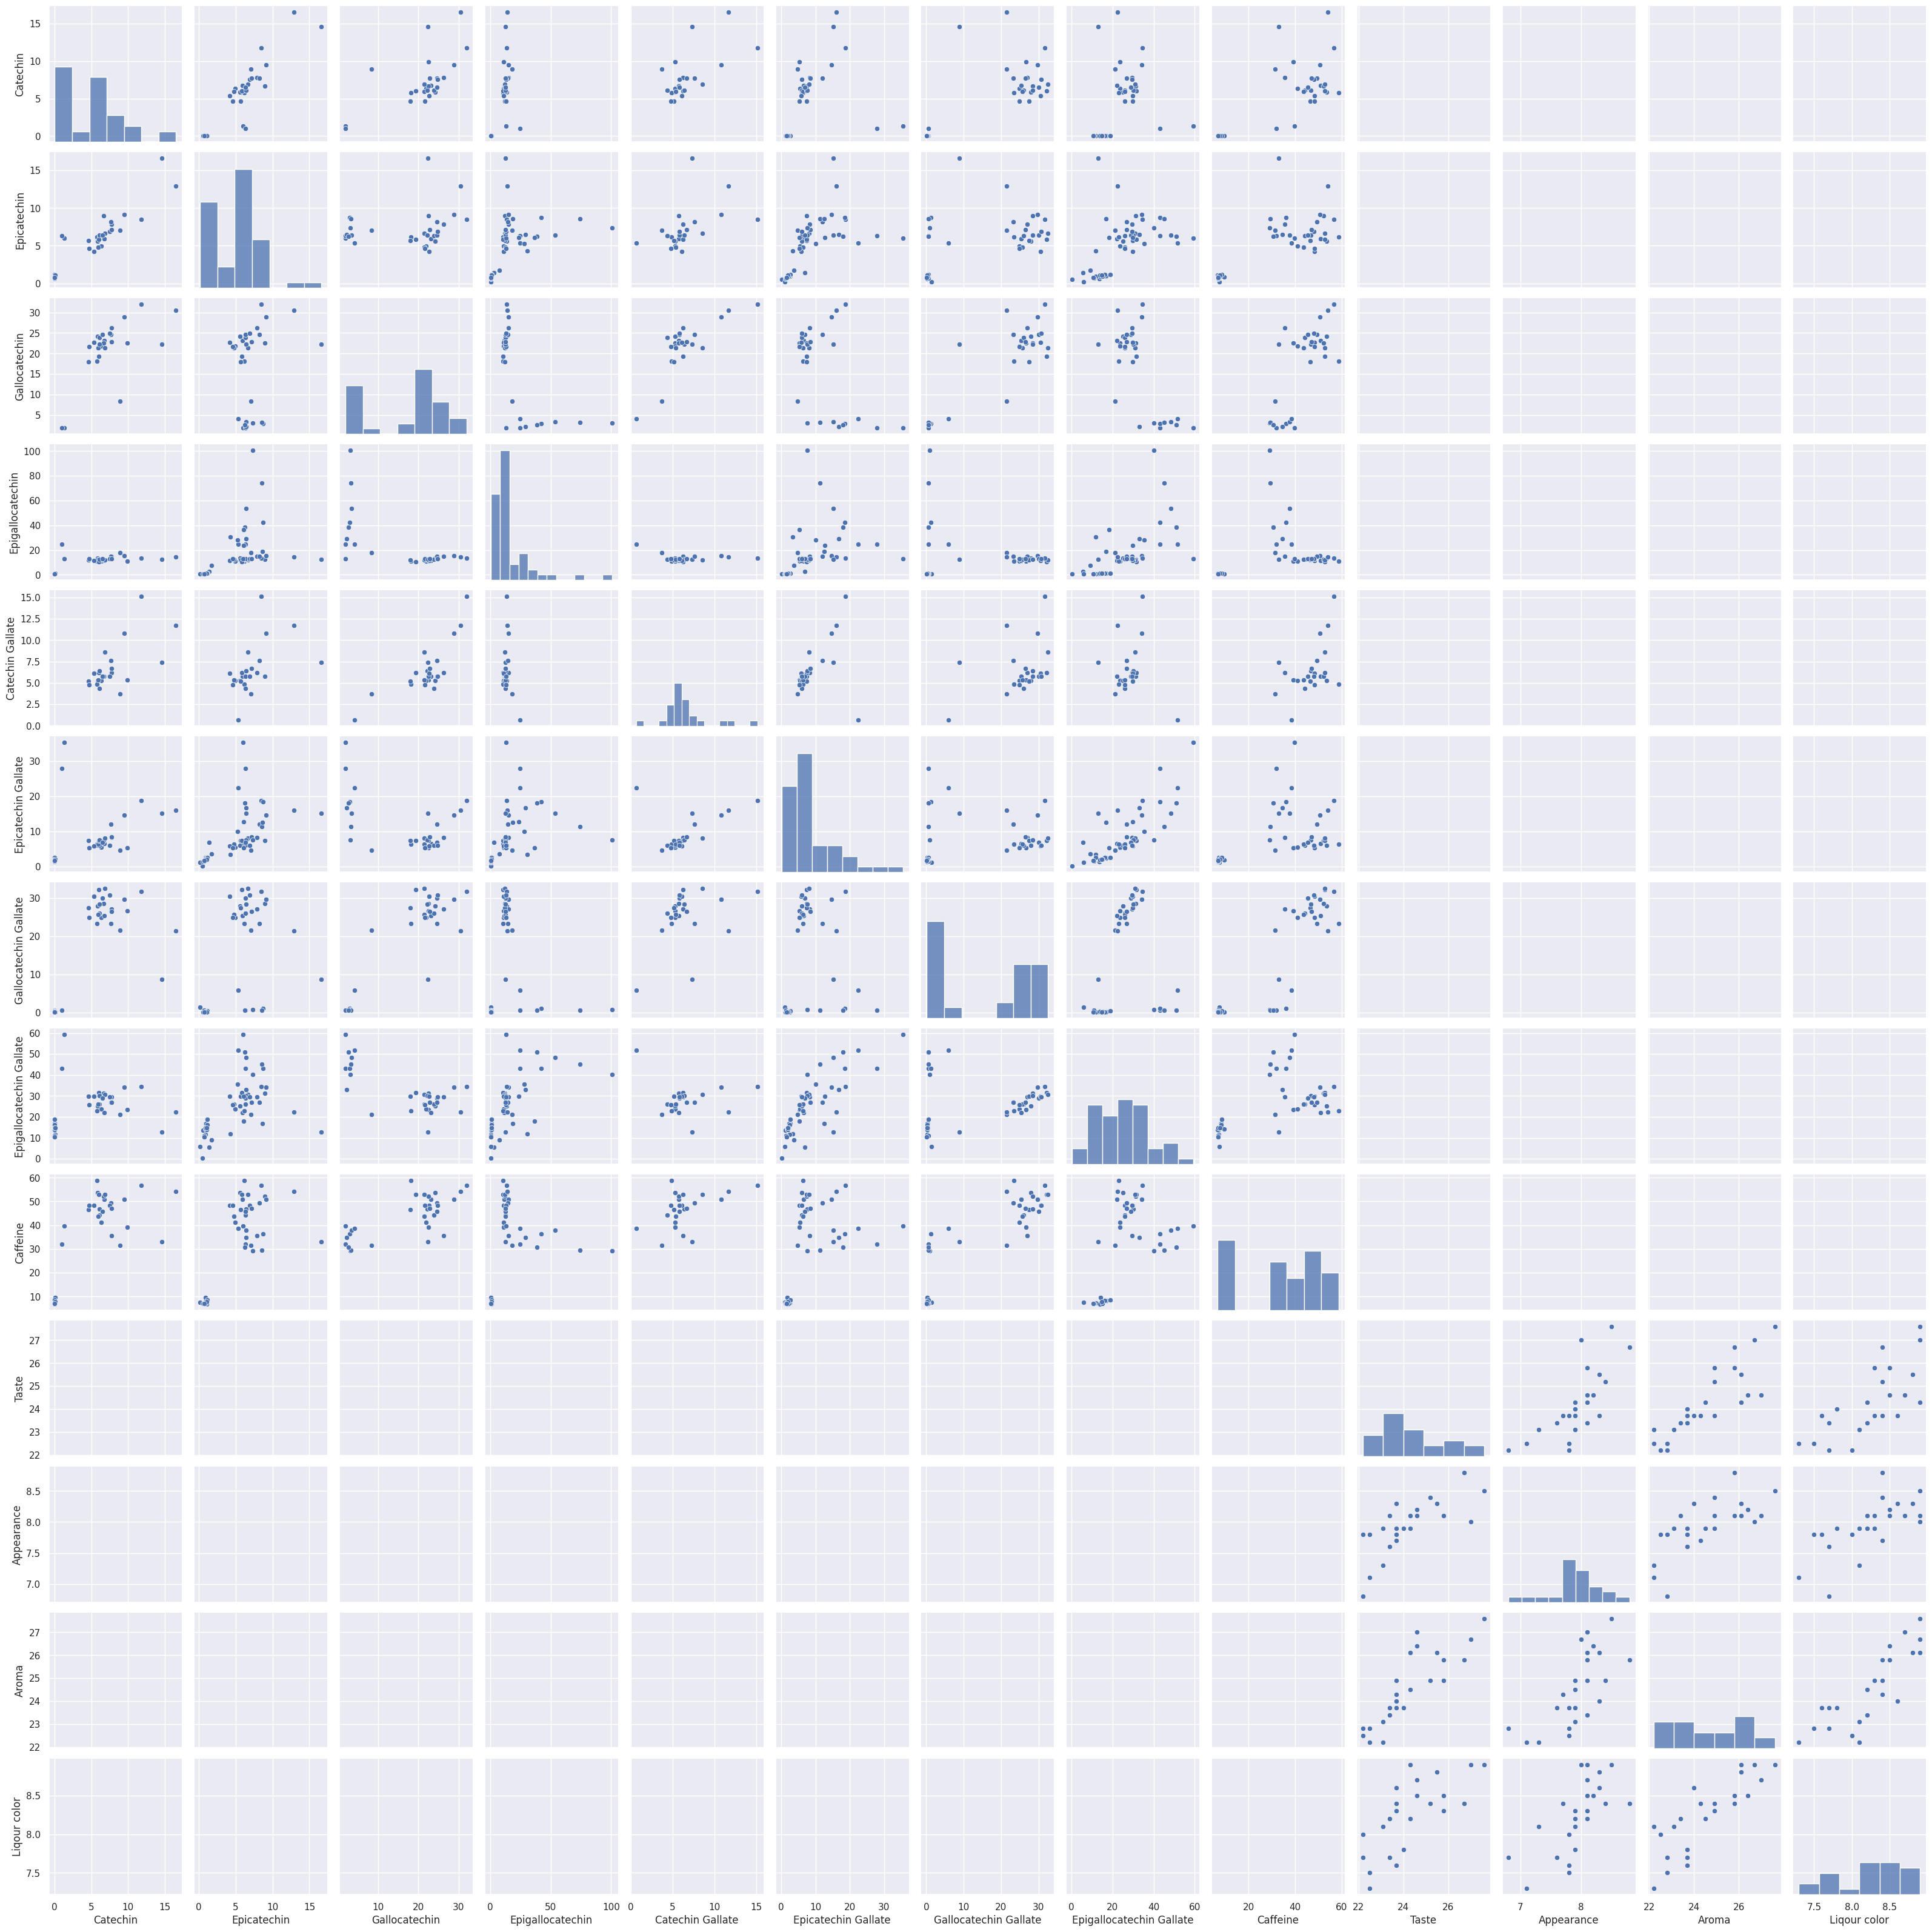

In [57]:
sns.set_theme()
sns.pairplot(df)

# Summary Statistics

In [59]:
df.describe()

,Catechin,Epicatechin,Gallocatechin,Epigallocatechin,Catechin Gallate,Epicatechin Gallate,Gallocatechin Gallate,Epigallocatechin Gallate,Caffeine,Taste,Appearance,Aroma,Liqour color
count,38.000000,53.000000,33.000000,54.000000,25.000000,54.000000,43.000000,54.000000,46.000000,24.000000,24.000000,24.000000,24.000000
mean,4.953763,5.154566,17.353697,16.055593,6.429800,8.401222,15.102884,25.275778,33.482761,24.275000,7.937500,24.545833,8.241667
std,4.369910,3.417688,9.884853,18.473702,2.804528,7.109934,13.432854,12.678468,17.913058,1.506291,0.436201,1.601352,0.461488
min,0.020000,0.190000,1.824000,0.570000,0.645000,0.070000,0.160000,0.300000,6.720000,22.200000,6.800000,22.200000,7.300000
25%,0.030000,1.190000,4.002000,1.602500,5.280000,2.780000,0.570000,15.207500,8.857500,23.325000,7.800000,23.325000,7.950000
50%,5.895000,5.910000,21.870000,12.465000,5.800000,6.405000,21.500000,25.445000,38.143000,23.850000,7.950000,24.400000,8.300000
75%,7.367500,6.910000,23.900000,17.290000,6.670000,11.808500,27.270000,31.090000,48.255000,25.275000,8.125000,25.875000,8.525000
max,16.540000,16.620000,32.020000,100.684000,15.150000,35.395000,32.540000,59.354000,58.830000,27.600000,8.800000,27.600000,8.900000


# Data Wrangling

# Training Device

As I am developing on Linux and training on Windows, this code displays if CUDA functionality is being used or not.

In [ ]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


# Generative Adversarial Network

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
            super(Generator, self).__init__()
            self.ngpu = ngpu

class Discriminator(nn.Module):    
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu

# Split data

In [ ]:
from torch.utils.data import DataLoader, random_split

train_size = int(0.8 * len(df))
test_size = len(df) - train_size
train_df, test_df = random_split(df, [train_size, test_size])

train_loader = DataLoader(train_df, batch_size=64, shuffle=True)
test_loader = DataLoader(test_df, batch_size=64, shuffle=True)

# Feature Engineering

# DBSCAN

In [ ]:
# Model Creation

In [ ]:
# Hyperparameter Selection

In [ ]:
# Model Training

# Multilayer Perceptron

In [ ]:
# Model Creation

In [ ]:
# Hyperparameter Selection

In [ ]:
# Model Training

# Convolutiontional Neural Network

In [ ]:
# Model Creation

In [ ]:
# Hyperparameter Selection


In [ ]:
# Model Training

# Model Visualization and Comparison

# Export model